## Machine Learning

### SetUp and Data Loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install --quiet seaborn
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Model interpretation
#import shap
from sklearn.inspection import permutation_importance

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the processed data
df = pd.read_csv('airbnb_processed_data.csv')
print(f"Loaded dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Quick overview
print(f"\nDataset overview:")
print(df.info())

Loaded dataset shape: (4988, 216)
Memory usage: 8.22 MB

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Columns: 216 entries, host_response_rate to text_appeal_category_Premium
dtypes: float64(31), int64(185)
memory usage: 8.2 MB
None


## Feature Selection & Engineering

### Correlation Analysis & Feature Filtering

In [50]:
# Identify target variable
target_col = 'price'
if target_col not in df.columns:
    print("Price column not found. Available columns:")
    print(df.columns.tolist())
    
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target statistics:")
print(y.describe())

# Remove features with too many missing values
missing_threshold = 0.1 
missing_pct = X.isnull().sum() / len(X)
high_missing_cols = missing_pct[missing_pct > missing_threshold].index
X = X.drop(columns=high_missing_cols)
print(f"Removed {len(high_missing_cols)} features with >{missing_threshold*100}% missing values")

# Remove features with near-zero variance
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0.005)
X_variance = variance_selector.fit_transform(X)
selected_features = X.columns[variance_selector.get_support()]
X = X[selected_features]
print(f"Removed {len(X.columns) - len(selected_features)} low-variance features")
print(f"Remaining features: {X.shape[1]}")

Features shape: (4988, 215)
Target shape: (4988,)
Target statistics:
count    4988.000000
mean       97.103649
std        87.529879
min        22.000000
25%        48.000000
50%        80.000000
75%       115.000000
max       713.000000
Name: price, dtype: float64
Removed 0 features with >10.0% missing values
Removed 0 low-variance features
Remaining features: 158


### Handle Multicollinearity

In [51]:
def remove_highly_correlated_features(df, threshold=0.95):
    """Remove highly correlated features"""
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()
    
    # Find pairs of highly correlated features
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > threshold)]
    
    return df.drop(columns=to_drop), to_drop

# Remove highly correlated features
X_reduced, dropped_corr_features = remove_highly_correlated_features(X, threshold=0.90)  
print(f"Removed {len(dropped_corr_features)} highly correlated features")
print(f"Final feature count: {X_reduced.shape[1]}")

# Update X with reduced features
X = X_reduced

Removed 16 highly correlated features
Final feature count: 142


### Feature Importance Analysis

Top 20 Most Important Features:
                                          feature  importance
24                               price_per_person    0.587058
7                                    accommodates    0.306648
9                                        bedrooms    0.044291
103                        room_type_Private room    0.011949
26                          availability_rate_365    0.006895
27                             people_per_bedroom    0.005296
19   calculated_host_listings_count_private_rooms    0.004989
3                       host_total_listings_count    0.002772
55                                name_word_count    0.002693
54                                    name_length    0.001912
12                           review_scores_rating    0.001235
10                                           beds    0.001218
82                         desc_exclamation_count    0.001036
6                                       longitude    0.001011
23                         days_since_

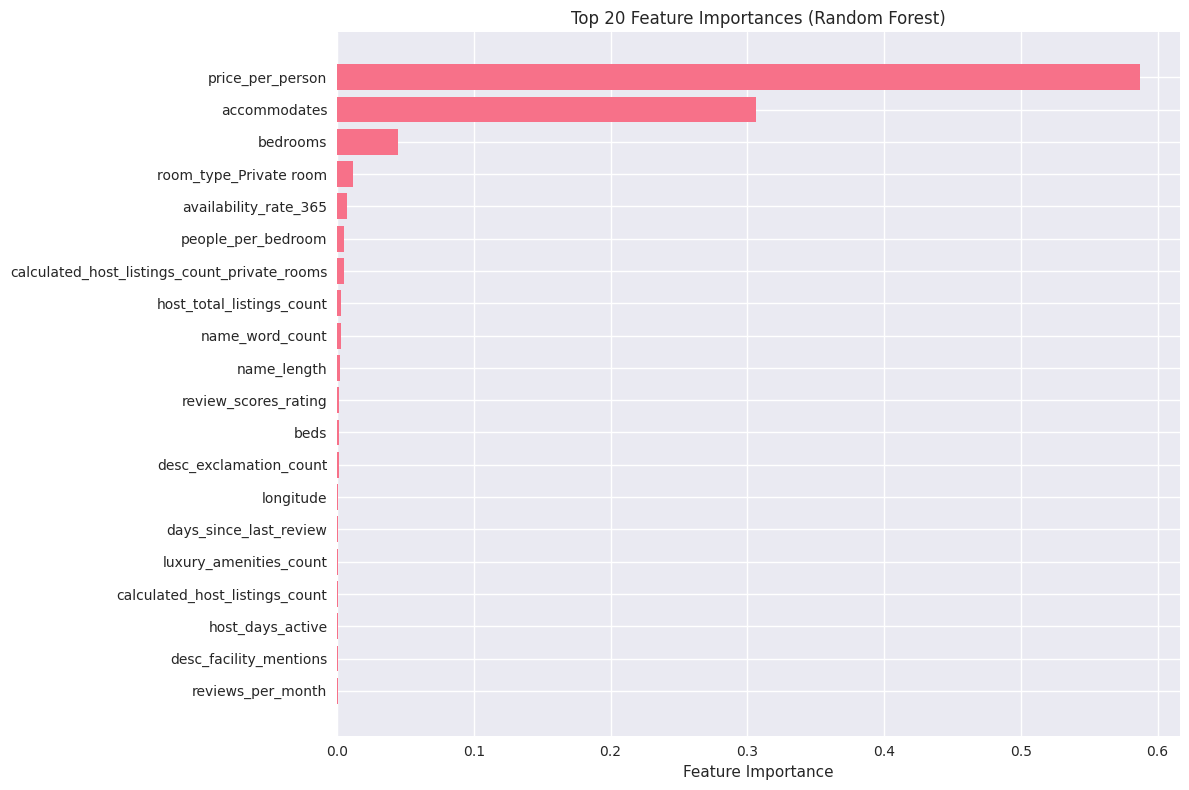

Selected 142 features for modeling


In [52]:
#Random Forest for feature importance
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X.fillna(X.median()), y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(20)['feature'][::-1], 
         feature_importance.head(20)['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Select top features for modeling
n_features = min(150, len(feature_importance))  
top_features = feature_importance.head(n_features)['feature'].tolist()
X_selected = X[top_features]
print(f"Selected {len(top_features)} features for modeling")

## Data Splitting & Preprocessing

### Train-Test Split

In [53]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=None
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Handle missing values in splits
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())  
X_test = X_test.fillna(X_train.median())  

Training set: (3192, 142)
Validation set: (798, 142)
Test set: (998, 142)


### Feature Scaling

In [55]:
# Initialise scalers
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

# Robust Scaler
scaler = scalers['robust']
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## Baseline Models

### Define Evaluation Functions

In [56]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    results = {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }
    
    return results

def plot_predictions(y_true, y_pred, model_name="Model"):
    """Plot actual vs predicted values"""
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name}: Actual vs Predicted')
    
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title(f'{model_name}: Residual Plot')
    
    plt.tight_layout()
    plt.show()

### Train Baseline Models

Training Linear Regression...
Linear Regression - Train R²: 0.5692, Val R²: 0.5735
Linear Regression - Train RMSE: 58.83, Val RMSE: 56.24
Training Ridge Regression...
Ridge Regression - Train R²: 0.5690, Val R²: 0.5739
Ridge Regression - Train RMSE: 58.85, Val RMSE: 56.21
Training Lasso Regression...
Lasso Regression - Train R²: 0.5345, Val R²: 0.5615
Lasso Regression - Train RMSE: 61.15, Val RMSE: 57.02
Training Decision Tree...
Decision Tree - Train R²: 1.0000, Val R²: 0.9748
Decision Tree - Train RMSE: 0.00, Val RMSE: 13.68
Training Random Forest...
Random Forest - Train R²: 0.9926, Val R²: 0.9788
Random Forest - Train RMSE: 7.69, Val RMSE: 12.54


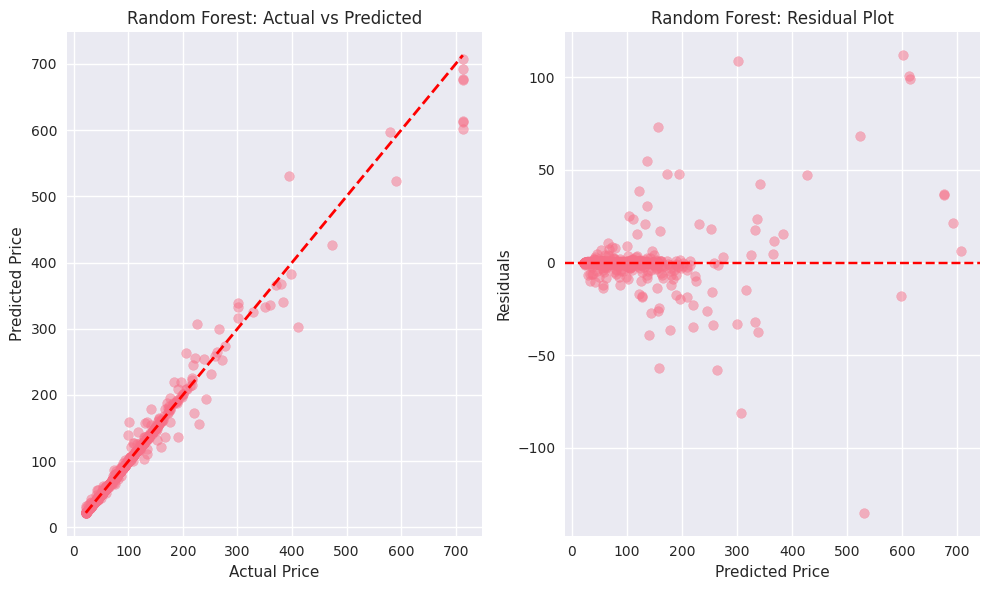


Baseline Model Results:
                       Model     RMSE      MAE      R²     MAPE
0  Linear Regression (Train)  58.8348  32.4168  0.5692  38.8592
1    Linear Regression (Val)  56.2360  32.7889  0.5735  39.7734
2   Ridge Regression (Train)  58.8480  32.3788  0.5690  38.7352
3     Ridge Regression (Val)  56.2108  32.7070  0.5739  39.6308
4   Lasso Regression (Train)  61.1540  31.0271  0.5345  34.6649
5     Lasso Regression (Val)  57.0204  30.4568  0.5615  34.1468
6      Decision Tree (Train)   0.0000   0.0000  1.0000   0.0000
7        Decision Tree (Val)  13.6752   3.5401  0.9748   2.1563
8      Random Forest (Train)   7.6933   1.7090  0.9926   1.0106
9        Random Forest (Val)  12.5412   3.4025  0.9788   2.1891


In [57]:
# Initialise models
baseline_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Store results
baseline_results = []

# Train and evaluate each model
for name, model in baseline_models.items():
    print(f"Training {name}...")
    
    # Use scaled data for linear models
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Train model
    model.fit(X_train_use, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_use)
    y_val_pred = model.predict(X_val_use)
    
    # Evaluate
    train_results = evaluate_model(y_train, y_train_pred, f"{name} (Train)")
    val_results = evaluate_model(y_val, y_val_pred, f"{name} (Val)")
    
    baseline_results.extend([train_results, val_results])
    
    # Print results
    print(f"{name} - Train R²: {train_results['R²']:.4f}, Val R²: {val_results['R²']:.4f}")
    print(f"{name} - Train RMSE: {train_results['RMSE']:.2f}, Val RMSE: {val_results['RMSE']:.2f}")
    
    # Plot for best performing model on validation
    if name == 'Random Forest':  
        plot_predictions(y_val, y_val_pred, name)

# Create results DataFrame
baseline_df = pd.DataFrame(baseline_results)
print("\nBaseline Model Results:")
print(baseline_df.round(4))

## Advanced Models

### Gradient Boosting Models

In [58]:
# Advanced models
advanced_models = {
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ),
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
}

# Train advanced models
advanced_results = []

for name, model in advanced_models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate
    train_results = evaluate_model(y_train, y_train_pred, f"{name} (Train)")
    val_results = evaluate_model(y_val, y_val_pred, f"{name} (Val)")
    
    advanced_results.extend([train_results, val_results])
    
    print(f"{name} - Train R²: {train_results['R²']:.4f}, Val R²: {val_results['R²']:.4f}")
    print(f"{name} - Validation RMSE: {val_results['RMSE']:.2f}")

# Create results DataFrame
advanced_df = pd.DataFrame(advanced_results)
print("\nAdvanced Model Results:")
print(advanced_df.round(4))

Training XGBoost...
XGBoost - Train R²: 0.9996, Val R²: 0.9697
XGBoost - Validation RMSE: 14.99
Training LightGBM...
LightGBM - Train R²: 0.9888, Val R²: 0.9781
LightGBM - Validation RMSE: 12.75
Training Gradient Boosting...
Gradient Boosting - Train R²: 0.9997, Val R²: 0.9877
Gradient Boosting - Validation RMSE: 9.55
Training Extra Trees...
Extra Trees - Train R²: 1.0000, Val R²: 0.9762
Extra Trees - Validation RMSE: 13.28

Advanced Model Results:
                       Model     RMSE     MAE      R²    MAPE
0            XGBoost (Train)   1.8190  1.1226  0.9996  1.2934
1              XGBoost (Val)  14.9899  3.8685  0.9697  2.8387
2           LightGBM (Train)   9.4792  3.3648  0.9888  3.0992
3             LightGBM (Val)  12.7508  4.4753  0.9781  3.8069
4  Gradient Boosting (Train)   1.5864  1.0449  0.9997  1.2481
5    Gradient Boosting (Val)   9.5461  3.0633  0.9877  2.4762
6        Extra Trees (Train)   0.0000  0.0000  1.0000  0.0000
7          Extra Trees (Val)  13.2790  3.8566  0.97

### Ensemble Methods

Best performing models: ['Gradient Boosting', 'Random Forest', 'LightGBM']

Ensemble Results:
R²: 0.9837
RMSE: 11.01


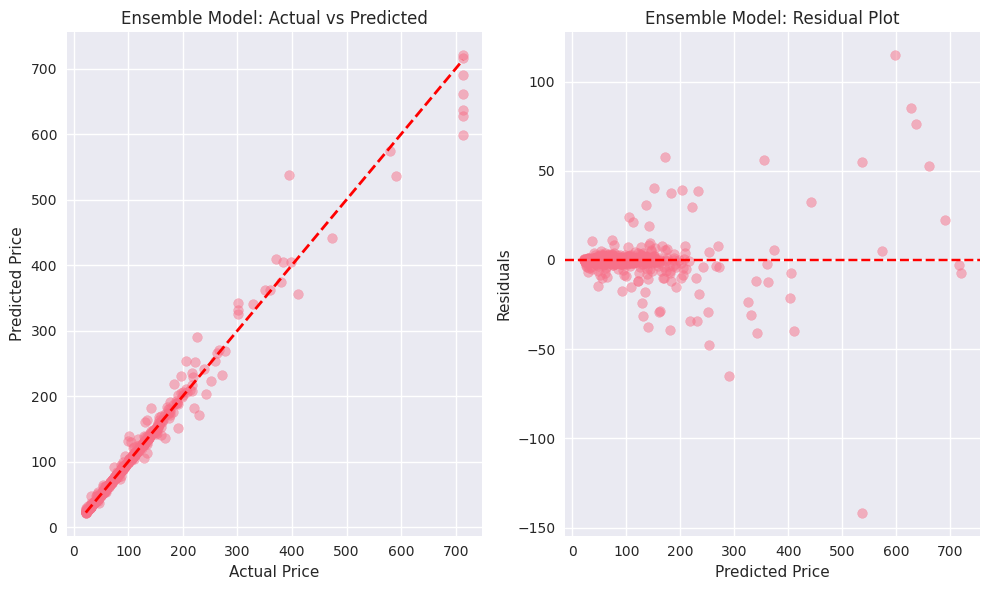

In [59]:
# Create ensemble of best models
from sklearn.ensemble import VotingRegressor

# Select best models based on validation performance
all_results = pd.concat([baseline_df, advanced_df])
val_results = all_results[all_results['Model'].str.contains('Val')]
best_models_names = val_results.nlargest(3, 'R²')['Model'].str.replace(' (Val)', '').tolist()

print(f"Best performing models: {best_models_names}")

# Create ensemble
ensemble_models = []
for name in best_models_names:
    if name == 'XGBoost':
        ensemble_models.append(('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)))
    elif name == 'Random Forest':
        ensemble_models.append(('rf', RandomForestRegressor(n_estimators=100, random_state=42)))
    elif name == 'LightGBM':
        ensemble_models.append(('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)))
    elif name == 'Extra Trees':
        ensemble_models.append(('et', ExtraTreesRegressor(n_estimators=100, random_state=42)))

if len(ensemble_models) >= 2:
    voting_regressor = VotingRegressor(estimators=ensemble_models[:3])  # Use top 3
    voting_regressor.fit(X_train, y_train)
    
    y_val_pred_ensemble = voting_regressor.predict(X_val)
    ensemble_results = evaluate_model(y_val, y_val_pred_ensemble, "Ensemble (Val)")
    
    print(f"\nEnsemble Results:")
    print(f"R²: {ensemble_results['R²']:.4f}")
    print(f"RMSE: {ensemble_results['RMSE']:.2f}")
    
    plot_predictions(y_val, y_val_pred_ensemble, "Ensemble Model")

## Model Evaluation & Comparison 

### Cross-Validation

In [60]:
from sklearn.model_selection import KFold

def perform_cv_manual(model, X, y, cv=5, model_name="Model"):
    """Perform cross-validation"""
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    rmse_scores = []
    r2_scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Fit model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred_fold = model.predict(X_val_fold)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        r2 = r2_score(y_val_fold, y_pred_fold)
        
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    return {
        'Model': model_name,
        'CV_RMSE_Mean': np.mean(rmse_scores),
        'CV_RMSE_Std': np.std(rmse_scores),
        'CV_R2_Mean': np.mean(r2_scores),
        'CV_R2_Std': np.std(r2_scores)
    }

# Perform CV on best models
cv_models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
}

cv_results = []

for name, model in cv_models.items():
    print(f"Training {name}...")
    try:
        cv_result = perform_cv_manual(model, X_train, y_train, cv=5, model_name=name)
        cv_results.append(cv_result)
        print(f"{name} - CV R²: {cv_result['CV_R2_Mean']:.4f} (±{cv_result['CV_R2_Std']:.4f})")
        print(f"   CV RMSE: £{cv_result['CV_RMSE_Mean']:.2f} (±{cv_result['CV_RMSE_Std']:.2f})")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        cv_results.append({
            'Model': name,
            'CV_RMSE_Mean': np.nan,
            'CV_RMSE_Std': np.nan,
            'CV_R2_Mean': np.nan,
            'CV_R2_Std': np.nan
        })
    print()

cv_df = pd.DataFrame(cv_results)
print("Cross-Validation Results Summary:")
print(cv_df.round(4))

Training XGBoost...
XGBoost - CV R²: 0.9612 (±0.0096)
   CV RMSE: £17.36 (±2.49)

Training Random Forest...
Random Forest - CV R²: 0.9522 (±0.0215)
   CV RMSE: £19.10 (±4.56)

Training LightGBM...
LightGBM - CV R²: 0.9466 (±0.0061)
   CV RMSE: £20.63 (±2.65)

Cross-Validation Results Summary:
           Model  CV_RMSE_Mean  CV_RMSE_Std  CV_R2_Mean  CV_R2_Std
0        XGBoost       17.3647       2.4896      0.9612     0.0096
1  Random Forest       19.0984       4.5618      0.9522     0.0215
2       LightGBM       20.6305       2.6493      0.9466     0.0061


## Hyperparameter Tuning

### XGBoost Hyperparameter Tuning

In [61]:
# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Grid Search
def manual_randomized_search(model_class, param_grid, X, y, n_iter=20, cv=3):
    """Manual implementation of randomised search"""
    import random
    
    best_score = float('inf')
    best_params = None
    all_results = []
    
    # Generate random parameter combinations
    param_combinations = []
    for _ in range(n_iter):
        params = {}
        for param, values in param_grid.items():
            params[param] = random.choice(values)
        param_combinations.append(params)
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    for i, params in enumerate(param_combinations):
        print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
        
        # Perform cross-validation 
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in kfold.split(X):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            # Create and train model
            model = model_class(random_state=42, n_jobs=-1, **params)
            model.fit(X_train_fold, y_train_fold)
            
            # Evaluate
            y_pred = model.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            cv_scores.append(rmse)
        
        mean_score = np.mean(cv_scores)
        all_results.append({'params': params, 'score': mean_score})
        
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
            print(f"New best score: {mean_score:.4f}")
        else:
            print(f"Score: {mean_score:.4f}")
    
    return best_params, best_score, all_results

# Perform hyperparameter tuning for XGBoost

try:
    best_xgb_params, best_xgb_score, xgb_results = manual_randomized_search(
        xgb.XGBRegressor, xgb_param_grid, X_train, y_train, n_iter=15, cv=3
    )
    
    print(f" Best XGBOOST results:")
    print(f"Best parameters: {best_xgb_params}")
    print(f"Best CV RMSE: £{best_xgb_score:.2f}")
    
    # Train final XGBoost model with best parameters
    best_xgb = xgb.XGBRegressor(random_state=42, n_jobs=-1, **best_xgb_params)
    best_xgb.fit(X_train, y_train)
    
    y_val_pred_tuned = best_xgb.predict(X_val)
    tuned_results = evaluate_model(y_val, y_val_pred_tuned, "Tuned XGBoost")
    print(f"Validation R²: {tuned_results['R²']:.4f}")
    print(f"Validation RMSE: £{tuned_results['RMSE']:.2f}")
    
except Exception as e:
    print(f"Error in hyperparameter tuning: {str(e)}")
    best_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
    best_xgb.fit(X_train, y_train)
    y_val_pred_tuned = best_xgb.predict(X_val)
    tuned_results = evaluate_model(y_val, y_val_pred_tuned, "Default XGBoost")
    print(f"Validation R²: {tuned_results['R²']:.4f}")
    print(f"Validation RMSE: £{tuned_results['RMSE']:.2f}")

Testing 15 parameter combinations...
Testing combination 1/15: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9, 'colsample_bytree': 0.8}
New best score: 39.7203
Testing combination 2/15: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8}
Score: 48.9276
Testing combination 3/15: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
New best score: 20.2827
Testing combination 4/15: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0}
Score: 44.6448
Testing combination 5/15: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}
New best score: 17.8279
Testing combination 6/15: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 0.9}
Score: 18.5902
Testing combination 7/15: {'n_estimators': 300, 'max_depth': 9, 'lear

### Random Forest Tuning

In [64]:
# Random Forest hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

try:
    best_rf_params, best_rf_score, rf_results = manual_randomized_search(
        RandomForestRegressor, rf_param_grid, X_train, y_train, n_iter=10, cv=3
    )
    
    print(f" Best Random Forest results:")
    print(f"Best parameters: {best_rf_params}")
    print(f"Best CV RMSE: £{best_rf_score:.2f}")
    
    # Train final RF model with best parameters
    best_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **best_rf_params)
    best_rf.fit(X_train, y_train)
    
    y_val_pred_rf_tuned = best_rf.predict(X_val)
    rf_tuned_results = evaluate_model(y_val, y_val_pred_rf_tuned, "Tuned Random Forest")
    print(f"Validation R²: {rf_tuned_results['R²']:.4f}")
    print(f"Validation RMSE: £{rf_tuned_results['RMSE']:.2f}")
    
except Exception as e:
    print(f"Error in Random Forest tuning: {str(e)}")
    print("Using default Random Forest parameters")
    best_rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
    best_rf.fit(X_train, y_train)
    y_val_pred_rf_tuned = best_rf.predict(X_val)
    rf_tuned_results = evaluate_model(y_val, y_val_pred_rf_tuned, "Default Random Forest")
    print(f"Validation R²: {rf_tuned_results['R²']:.4f}")
    print(f"Validation RMSE: £{rf_tuned_results['RMSE']:.2f}")

Testing 10 parameter combinations...
Testing combination 1/10: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
New best score: 56.7672
Testing combination 2/10: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}
Score: 61.4538
Testing combination 3/10: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
Score: 57.9984
Testing combination 4/10: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
Score: 60.0665
Testing combination 5/10: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}
Score: 60.8300
Testing combination 6/10: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}
Score: 61.4538
Testing combination 7/10: {'n_estimators': 100,

In [68]:
# Compare models and select the best one
print(f"Model Comoparison:")
print(f"XGBoost    - R²: {tuned_results['R²']:.4f}, RMSE: ${tuned_results['RMSE']:.2f}")
print(f"Random Forest - R²: {rf_tuned_results['R²']:.4f}, RMSE: ${rf_tuned_results['RMSE']:.2f}")

# Select the better model
if tuned_results['R²'] >= rf_tuned_results['R²']:
    final_model = best_xgb
    final_model_name = "XGBoost"
    final_results_val = tuned_results
    print(f"Selected model: XGBoost (R² = {tuned_results['R²']:.4f})")
else:
    final_model = best_rf
    final_model_name = "Random Forest"
    final_results_val = rf_tuned_results
    print(f"Selected model: Random Forest (R² = {rf_tuned_results['R²']:.4f})")

# Store the best model for later use
best_overall_model = final_model

Model Comoparison:
XGBoost    - R²: 0.9833, RMSE: $11.12
Random Forest - R²: 0.9750, RMSE: $13.62
Selected model: XGBoost (R² = 0.9833)


## Model Interpretation 

### Feature Importance Analysis

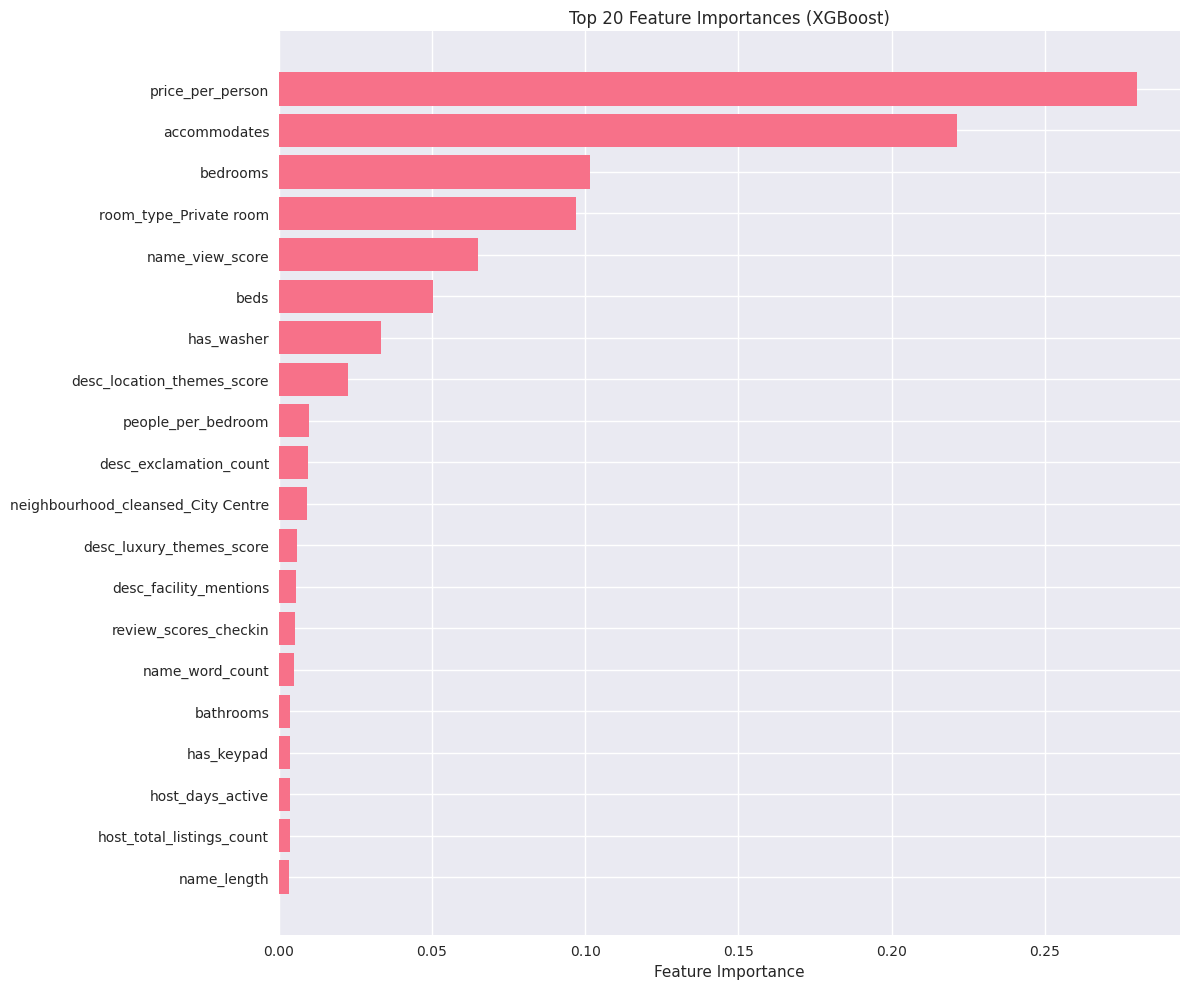

Top 10 Most Important Features:
price_per_person........................ 0.2801
accommodates............................ 0.2212
bedrooms................................ 0.1015
room_type_Private room.................. 0.0970
name_view_score......................... 0.0649
beds.................................... 0.0502
has_washer.............................. 0.0335
desc_location_themes_score.............. 0.0226
people_per_bedroom...................... 0.0099
desc_exclamation_count.................. 0.0096


In [69]:
# Feature importance from best model
try:
    if hasattr(final_model, 'feature_importances_'):
        feature_importance_final = pd.DataFrame({
            'feature': X_train.columns,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 10))
        top_20_features = feature_importance_final.head(20)
        plt.barh(top_20_features['feature'][::-1], top_20_features['importance'][::-1])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 20 Feature Importances ({final_model_name})')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        for i, row in feature_importance_final.head(10).iterrows():
            print(f"{row['feature']:.<40} {row['importance']:.4f}")
            
    else:
        print("Selected model doesn't have feature_importances_ attribute")
        feature_importance_final = pd.DataFrame({
            'feature': X_train.columns,
            'importance': [0.01] * len(X_train.columns) 
        })
        
except Exception as e:
    print(f"Error in feature importance analysis: {str(e)}")
    feature_importance_final = pd.DataFrame({
        'feature': X_train.columns,
        'importance': [0.01] * len(X_train.columns) 
    })

### Permutation Importance

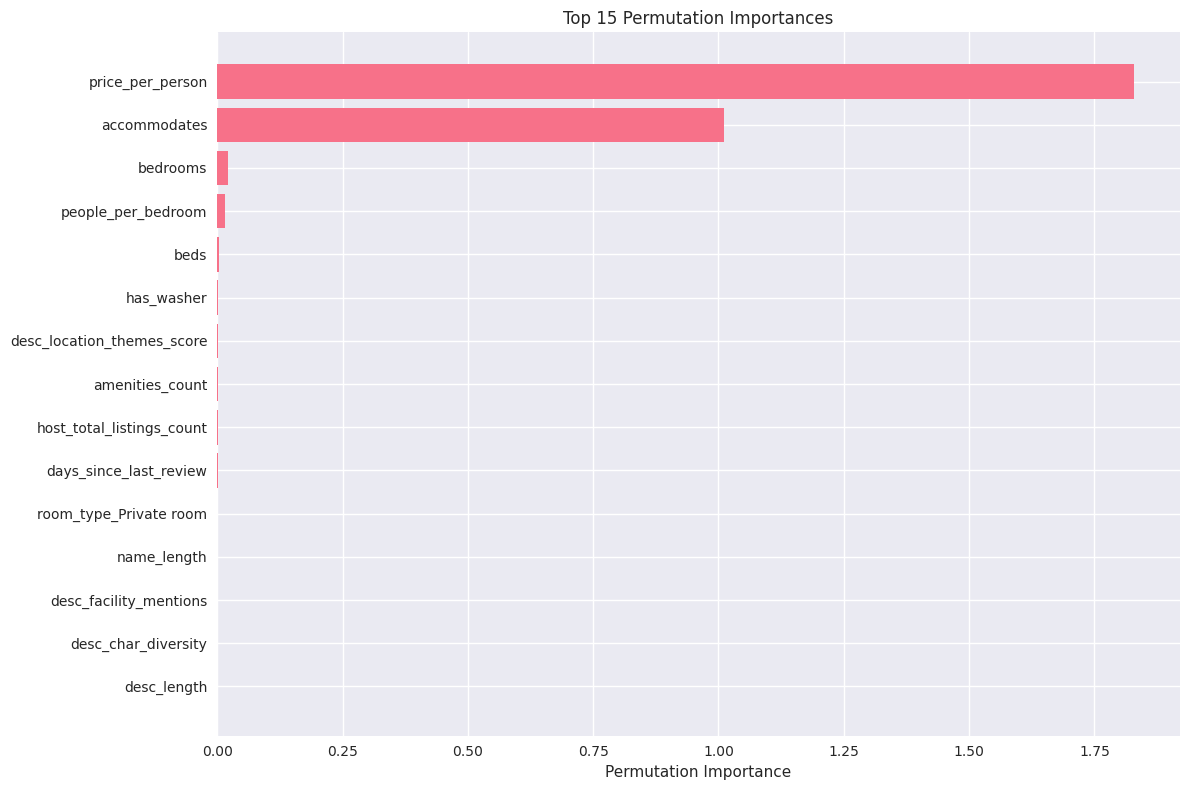

Top 10 Permutation Importance Features:
                       feature  importance       std
0             price_per_person    1.829230  0.100429
1                 accommodates    1.010267  0.047983
2                     bedrooms    0.022091  0.000826
5           people_per_bedroom    0.015790  0.001077
11                        beds    0.003573  0.001152
97                  has_washer    0.001501  0.001480
29  desc_location_themes_score    0.001280  0.001567
27             amenities_count    0.000755  0.000215
7    host_total_listings_count    0.000741  0.000288
14      days_since_last_review    0.000605  0.000111


In [70]:
# Permutation importance
perm_importance = permutation_importance(
    best_xgb, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 8))
top_15_perm = perm_df.head(15)
plt.barh(top_15_perm['feature'][::-1], top_15_perm['importance'][::-1])
plt.xlabel('Permutation Importance')
plt.title('Top 15 Permutation Importances')
plt.tight_layout()
plt.show()

print("Top 10 Permutation Importance Features:")
print(perm_df.head(10))

## Final Model & Deployment Prep

## Set up for Streamlit 

In [74]:
# Load your processed data
df = pd.read_csv('airbnb_processed_data.csv')

# Separate target
target_col = 'price'
X = df.drop(columns=[target_col])
y = df[target_col]

# Remove price_per_person to avoid data leakage
if 'price_per_person' in X.columns:
    X = X.drop(columns=['price_per_person'])

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# Drop rows with missing target
valid_mask = y.notna()
X = X[valid_mask]
y = y[valid_mask]

# Fill missing values
X = X.fillna(X.median())

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Evaluate
y_test_pred = model.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Model performance")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: £{test_rmse:.2f}")

# Save everything
import joblib
joblib.dump(model, 'original_airbnb_model.pkl')
joblib.dump(scaler, 'original_scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'original_feature_columns.pkl')
joblib.dump(X_train.median().to_dict(), 'feature_defaults.pkl')


Features: 214
Samples: 4988
Model performance
Test R²: 0.4910
Test RMSE: £58.21


['feature_defaults.pkl']